# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 3,
        'fully_grown': True,          
        'dt_type': 'SDT', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [0,1,2],
        
        'function_generation_type': 'random_decision_tree',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1, 
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': 15,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets10000_var10_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth3_beta1_decisionSpars3_SDT_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets10000_var10_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth3_beta1_decisionSpars3_SDT_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)

## Data Inspection

In [10]:
function_df.head()

,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1
0,0.000,0.000,0.000,0.000,-0.266,0.176,0.000,0.000,0.000,-0.171,0.000,0.000,-0.312,0.000,0.000,0.000,-0.248,-0.197,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.289,0.000,0.000,-0.276,0.263,0.000,0.000,0.000,0.000,0.273,0.000,0.000,0.231,0.000,0.248,0.233,0.000,0.000,0.000,-0.226,0.000,0.000,0.000,0.228,0.000,0.232,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.272,-0.232,0.000,0.000,0.000,0.000,0.222,-0.264,0.000,-0.228,0.000,0.000,-0.230,-0.136,0.269,0.291,-0.087,-0.027,-0.287,0.068,-0.313,-0.123,-0.074,0.290,-0.019,0.332,0.195,-0.013,-0.139,-0.322,0.263,-0.195,-0.019,-0.341,-0.209
1,0.000,0.000,0.000,0.000,0.211,0.000,0.000,0.240,-0.287,0.000,0.000,0.000,0.240,0.292,0.000,0.000,0.000,-0.246,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.268,-0.211,0.000,-0.200,-0.214,0.000,0.000,0.199,0.000,0.000,0.268,0.000,0.000,0.000,0.000,0.000,-0.270,0.000,0.000,0.000,0.000,0.000,0.281,0.265,0.000,0.000,0.000,-0.308,0.000,-0.278,0.211,0.000,0.000,0.000,-0.244,0.000,0.000,0.000,0.000,0.271,0.000,-0.254,0.000,0.000,-0.278,0.311,0.120,-0.251,0.310,0.203,0.267,-0.193,-0.014,0.129,0.298,-0.097,-0.088,0.017,0.292,0.281,0.169,0.219,-0.137,-0.091,-0.133,0.139,-0.258
2,-0.157,0.000,0.000,0.000,0.000,0.000,0.000,-0.162,-0.245,0.000,0.000,0.000,0.000,0.276,-0.289,0.000,0.000,0.276,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.312,0.255,0.000,-0.256,0.000,0.000,0.000,0.000,0.000,0.000,0.265,0.000,-0.294,0.000,0.239,0.000,0.000,0.230,0.000,0.265,0.000,-0.193,0.000,0.000,0.000,0.000,0.000,0.316,0.237,-0.230,0.000,0.000,0.000,0.000,0.000,-0.213,0.000,0.000,0.000,0.000,0.221,0.000,0.000,-0.224,0.000,0.146,-0.281,0.012,-0.185,0.267,-0.109,-0.026,0.347,-0.245,0.170,-0.232,-0.203,-0.346,0.190,0.207,0.141,-0.297,-0.229,-0.102,-0.328,-0.047,-0.021,0.083
3,0.000,0.232,0.000,0.000,0.000,0.000,0.173,0.000,0.000,-0.195,0.000,0.282,0.000,0.000,0.279,0.000,0.260,0.000,0.000,0.000,0.000,0.000,0.217,0.000,0.169,0.000,0.000,-0.221,0.000,0.000,0.000,0.000,0.211,-0.280,0.000,0.000,0.000,0.225,0.000,0.000,0.000,0.271,0.000,-0.291,0.000,0.000,0.000,0.000,0.000,0.286,0.000,0.158,0.170,0.000,0.000,0.000,0.000,0.000,-0.157,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.262,0.000,-0.291,-0.311,-0.307,0.260,0.169,0.197,0.052,-0.079,-0.018,0.052,-0.013,-0.259,-0.192,0.281,-0.137,-0.277,-0.055,0.338,0.092,0.311,0.327,0.336,-0.086,-0.132,0.083
4,0.000,0.000,0.000,0.000,-0.312,0.000,0.312,0.000,0.000,0.300,0.000,0.000,0.270,0.000,0.000,0.187,0.000,0.000,0.000,-0.292,0.000,0.000,0.000,0.000,0.270,0.000,0.158,0.000,0.281,0.000,0.264,0.000,0.000,0.000,0.292,0.000,0.000,0.000,0.255,0.000,0.000,0.000,0.277,0.000,0.000,0.266,0.000,0.000,0.000,0.307,0.000,0.000,0.000,-0.303,-0.316,0.000,0.000,0.280,0.000,0.000,-0.225,0.000,-0.305,0.000,0.000,0.000,0.000,-0.219,0.000,0.000,0.045,-0.277,-0.160,-0.149,-0.172,0.269,0.179,0.146,0.014,-0.106,0.224,-0.287,0.149,0.075,-0.249,0.327,-0.333,0.157,0.105,-0.285,0.173,-0.031,0.203


In [11]:
X_data_list[0][0].head(10)

f0v0    0.000
f0v1    0.000
f0v2    0.000
f0v3    0.000
f0v4   -0.266
f0v5    0.176
f0v6    0.000
f0v7    0.000
f0v8    0.000
f0v9   -0.171
dtype: float32

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,1.000,1.000,1.000,0.545,0.424,0.646,0.438,0.892,0.964,0.383
1,1.000,1.000,1.000,0.926,0.071,0.087,0.020,0.833,0.778,0.870
2,1.000,1.000,0.000,0.781,0.118,0.640,0.143,0.945,0.522,0.415
3,0.000,1.000,0.000,0.568,0.019,0.618,0.612,0.617,0.944,0.682
4,0.000,0.000,1.000,0.060,0.667,0.671,0.210,0.129,0.315,0.364
5,1.000,0.000,1.000,0.102,0.209,0.161,0.653,0.253,0.466,0.244
6,0.000,0.000,1.000,0.138,0.197,0.369,0.821,0.097,0.838,0.096
7,1.000,0.000,1.000,0.605,0.739,0.039,0.283,0.120,0.296,0.119
8,0.000,0.000,0.000,0.692,0.567,0.265,0.523,0.094,0.576,0.929
9,0.000,1.000,0.000,0.716,0.289,0.183,0.587,0.020,0.829,0.005


In [13]:
y_data_list[0][0].head(10)

f0v0    0.000
f0v1    0.000
f0v2    0.000
f0v3    0.000
f0v4   -0.266
f0v5    0.176
f0v6    0.000
f0v7    0.000
f0v8    0.000
f0v9   -0.171
dtype: float32

In [14]:
y_data_list[0][1].head(10)

,result
0,1.000
1,0.000
2,1.000
3,1.000
4,1.000
5,0.000
6,1.000
7,0.000
8,1.000
9,1.000


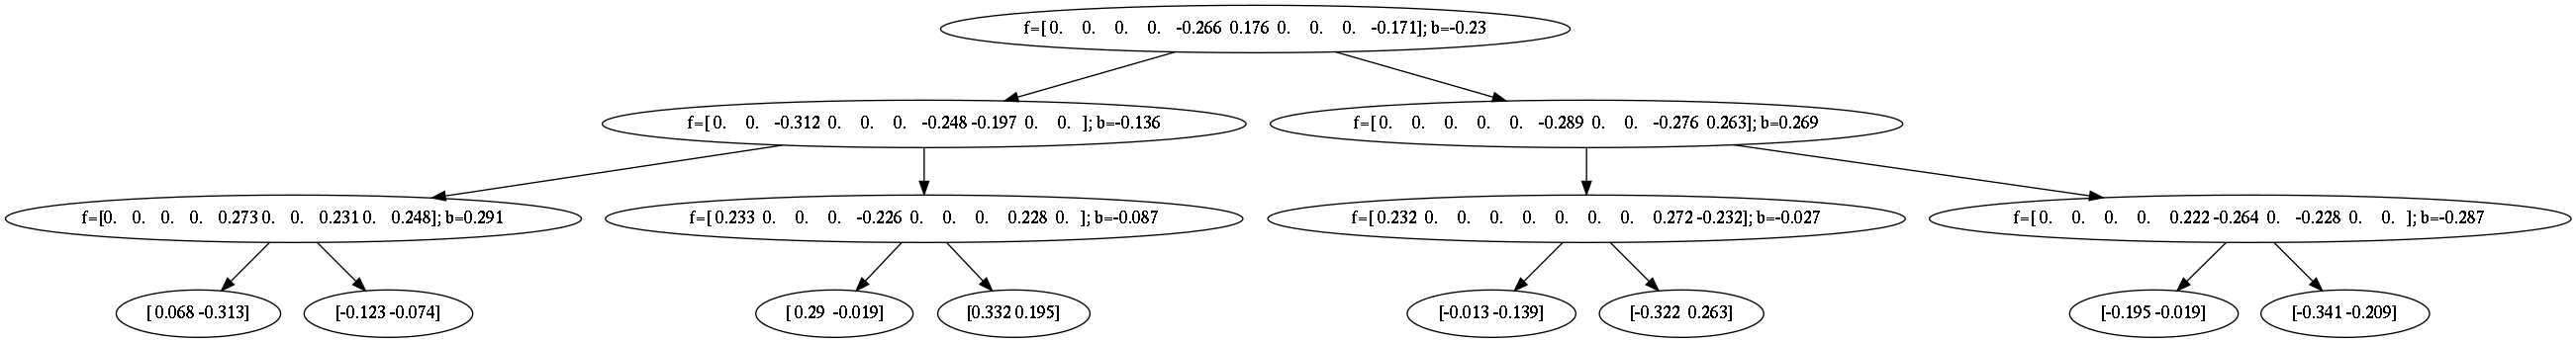

In [15]:
plot_tree_from_parameters(y_data_list[0][0].values, config)

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        #y_data[1].reshape(-1, 1)
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

f0v0    0.000
f0v1    0.000
f0v2    0.000
f0v3    0.000
f0v4   -0.266
f0v5    0.176
f0v6    0.000
f0v7    0.000
f0v8    0.000
f0v9   -0.171
dtype: float32

In [19]:
y_data_list[0][0]

f0v0     0.000
f0v1     0.000
f0v2     0.000
f0v3     0.000
f0v4    -0.266
         ...  
lp5c1    0.263
lp6c0   -0.195
lp6c1   -0.019
lp7c0   -0.341
lp7c1   -0.209
Length: 93, dtype: float32

In [20]:
y_data_list[0][1].head(10)

,result
0,1.000
1,0.000
2,1.000
3,1.000
4,1.000
5,0.000
6,1.000
7,0.000
8,1.000
9,1.000


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

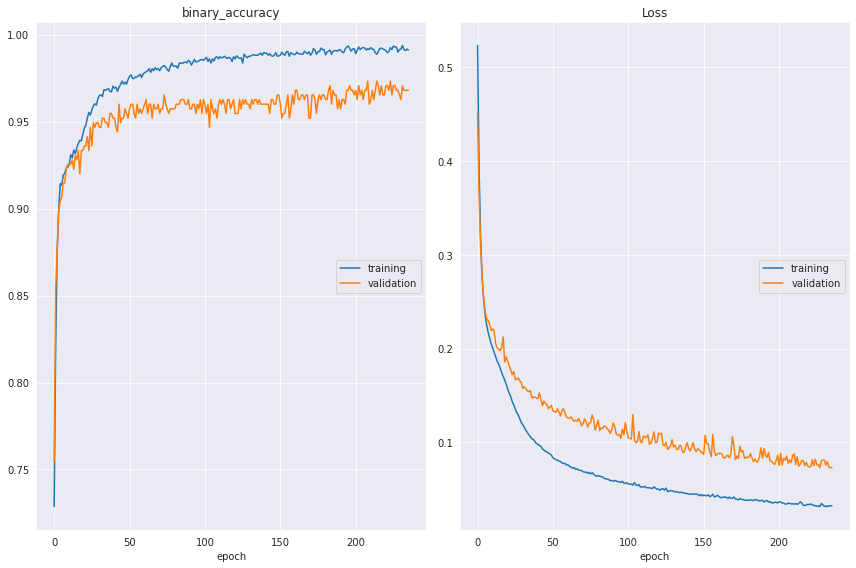

binary_accuracy
	training         	 (min:    0.729, max:    0.994, cur:    0.991)
	validation       	 (min:    0.755, max:    0.973, cur:    0.968)
Loss
	training         	 (min:    0.031, max:    0.523, cur:    0.032)
	validation       	 (min:    0.073, max:    0.451, cur:    0.073)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [24]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list, y_data_list)))  
del parallel

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:   43.8s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:  3.5min
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:  7.5min
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed: 13.0min
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed: 20.0min
[Parallel(n_jobs=15)]: Done 1122 tasks      | elapsed: 28.7min
[Parallel(n_jobs=15)]: Done 1538 tasks      | elapsed: 39.3min
[Parallel(n_jobs=15)]: Done 2018 tasks      | elapsed: 51.2min
[Parallel(n_jobs=15)]: Done 2562 tasks      | elapsed: 64.6min
[Parallel(n_jobs=15)]: Done 3170 tasks      | elapsed: 79.9min
[Parallel(n_jobs=15)]: Done 3842 tasks      | elapsed: 96.7min
[Parallel(n_jobs=15)]: Done 4578 tasks      | elapsed: 115.1min
[Parallel(n_jobs=15)]: Done 5378 tasks      | elapsed: 131.6min
[Parallel(n_jobs=15)]: Done 6242 tasks      | elapsed: 146.9min
[Parallel(n_jobs=15)]: Done 7170 tasks     

In [25]:
random_network['model'].get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initial

In [26]:
random_network['model'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [27]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [28]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [29]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_217,loss_epoch_218,loss_epoch_219,loss_epoch_220,loss_epoch_221,loss_epoch_222,loss_epoch_223,loss_epoch_224,loss_epoch_225,loss_epoch_226,loss_epoch_227,loss_epoch_228,loss_epoch_229,loss_epoch_230,loss_epoch_231,loss_epoch_232,loss_epoch_233,loss_epoch_234,loss_epoch_235,loss_epoch_236,loss_epoch_237,loss_epoch_238,loss_epoch_239,loss_epoch_240,loss_epoch_241,loss_epoch_242,loss_epoch_243,loss_epoch_244,loss_epoch_245,loss_epoch_246,loss_epoch_247,loss_epoch_248,loss_epoch_249,loss_epoch_250,loss_epoch_251,loss_epoch_252,loss_epoch_253,loss_epoch_254,loss_epoch_255,loss_epoch_256,loss_epoch_257,loss_epoch_258,loss_epoch_259,loss_epoch_260,loss_epoch_261,loss_epoch_262,loss_epoch_263,loss_epoch_264,loss_epoch_265,loss_epoch_266,loss_epoch_267,loss_epoch_268,loss_epoch_269,loss_epoch_270,loss_epoch_271,loss_epoch_272,loss_epoch_273,loss_epoch_274,loss_epoch_275,loss_epoch_276,loss_epoch_277,loss_epoch_278,loss_epoch_279,loss_epoch_280,loss_epoch_281,loss_epoch_282,loss_epoch_283,loss_epoch_284,loss_epoch_285,loss_epoch_286,loss_epoch_287,loss_epoch_288,loss_epoch_289,loss_epoch_290,loss_epoch_291,loss_epoch_292,loss_epoch_293,loss_epoch_294,loss_epoch_295,loss_epoch_296,loss_epoch_297,loss_epoch_298,loss_epoch_299,loss_epoch_300,loss_epoch_301,loss_epoch_302,loss_epoch_303,loss_epoch_304,loss_epoch_305,loss_epoch_306,loss_epoch_307,loss_epoch_308,loss_epoch_309,loss_epoch_310,loss_epoch_311,loss_epoch_312,loss_epoch_313,loss_epoch_314,loss_epoch_315,loss_epoch_316
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9998.000,9997.000,9997.000,9997.000,9996.000,9996.000,9994.000,9991.000,9991.000,9990.000,9988.000,9983.000,9982.000,9981.000,9979.000,9979.000,9977.000,9977.000,9975.000,9972.000,9972.000,9971.000,9967.000,9960.000,9959.000,9955.000,9951.000,9945.000,9933.000,9929.000,9919.000,9909.000,9903.000,9896.000,9890.000,9879.000,9868.000,9856.000,9841.000,9827.000,9814.000,9802.000,...,697.000,668.000,631.000,613.000,591.000,565.000,539.000,512.000,482.000,464.000,443.000,419.000,397.000,384.000,365.000,351.000,333.000,321.000,

In [30]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_217,val_loss_epoch_218,val_loss_epoch_219,val_loss_epoch_220,val_loss_epoch_221,val_loss_epoch_222,val_loss_epoch_223,val_loss_epoch_224,val_loss_epoch_225,val_loss_epoch_226,val_loss_epoch_227,val_loss_epoch_228,val_loss_epoch_229,val_loss_epoch_230,val_loss_epoch_231,val_loss_epoch_232,val_loss_epoch_233,val_loss_epoch_234,val_loss_epoch_235,val_loss_epoch_236,val_loss_epoch_237,val_loss_epoch_238,val_loss_epoch_239,val_loss_epoch_240,val_loss_epoch_241,val_loss_epoch_242,val_loss_epoch_243,val_loss_epoch_244,val_loss_epoch_245,val_loss_epoch_246,val_loss_epoch_247,val_loss_epoch_248,val_loss_epoch_249,val_loss_epoch_250,val_loss_epoch_251,val_loss_epoch_252,val_loss_epoch_253,val_loss_epoch_254,val_loss_epoch_255,val_loss_epoch_256,val_loss_epoch_257,val_loss_epoch_258,val_loss_epoch_259,val_loss_epoch_260,val_loss_epoch_261,val_loss_epoch_262,val_loss_epoch_263,val_loss_epoch_264,val_loss_epoch_265,val_loss_epoch_266,val_loss_epoch_267,val_loss_epoch_268,val_loss_epoch_269,val_loss_epoch_270,val_loss_epoch_271,val_loss_epoch_272,val_loss_epoch_273,val_loss_epoch_274,val_loss_epoch_275,val_loss_epoch_276,val_loss_epoch_277,val_loss_epoch_278,val_loss_epoch_279,val_loss_epoch_280,val_loss_epoch_281,val_loss_epoch_282,val_loss_epoch_283,val_loss_epoch_284,val_loss_epoch_285,val_loss_epoch_286,val_loss_epoch_287,val_loss_epoch_288,val_loss_epoch_289,val_loss_epoch_290,val_loss_epoch_291,val_loss_epoch_292,val_loss_epoch_293,val_loss_epoch_294,val_loss_epoch_295,val_loss_epoch_296,val_loss_epoch_297,val_loss_epoch_298,val_loss_epoch_299,val_loss_epoch_300,val_loss_epoch_301,val_loss_epoch_302,val_loss_epoch_303,val_loss_epoch_304,val_loss_epoch_305,val_loss_epoch_306,val_loss_epoch_307,val_loss_epoch_308,val_loss_epoch_309,val_loss_epoch_310,val_loss_epoch_311,val_loss_epoch_312,val_loss_epoch_313,val_loss_epoch_314,val_loss_epoch_315,val_loss_epoch_316
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,

In [31]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_217,binary_accuracy_epoch_218,binary_accuracy_epoch_219,binary_accuracy_epoch_220,binary_accuracy_epoch_221,binary_accuracy_epoch_222,binary_accuracy_epoch_223,binary_accuracy_epoch_224,binary_accuracy_epoch_225,binary_accuracy_epoch_226,binary_accuracy_epoch_227,binary_accuracy_epoch_228,binary_accuracy_epoch_229,binary_accuracy_epoch_230,binary_accuracy_epoch_231,binary_accuracy_epoch_232,binary_accuracy_epoch_233,binary_accuracy_epoch_234,binary_accuracy_epoch_235,binary_accuracy_epoch_236,binary_accuracy_epoch_237,binary_accuracy_epoch_238,binary_accuracy_epoch_239,binary_accuracy_epoch_240,binary_accuracy_epoch_241,binary_accuracy_epoch_242,binary_accuracy_epoch_243,binary_accuracy_epoch_244,binary_accuracy_epoch_245,binary_accuracy_epoch_246,binary_accuracy_epoch_247,binary_accuracy_epoch_248,binary_accuracy_epoch_249,binary_accuracy_epoch_250,binary_accuracy_epoch_251,binary_accuracy_epoch_252,binary_accuracy_epoch_253,binary_accuracy_epoch_254,binary_accuracy_epoch_255,binary_accuracy_epoch_256,binary_accuracy_epoch_257,binary_accuracy_epoch_258,binary_accuracy_epoch_259,binary_accuracy_epoch_260,binary_accuracy_epoch_261,binary_accuracy_epoch_262,binary_accuracy_epoch_263,binary_accuracy_epoch_264,binary_accuracy_epoch_265,binary_accuracy_epoch_266,binary_accuracy_epoch_267,binary_accuracy_epoch_268,binary_accuracy_epoch_269,binary_accuracy_epoch_270,binary_accuracy_epoch_271,binary_accuracy_epoch_272,binary_accuracy_epoch_273,binary_accuracy_epoch_274,binary_accuracy

In [32]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_217,val_binary_accuracy_epoch_218,val_binary_accuracy_epoch_219,val_binary_accuracy_epoch_220,val_binary_accuracy_epoch_221,val_binary_accuracy_epoch_222,val_binary_accuracy_epoch_223,val_binary_accuracy_epoch_224,val_binary_accuracy_epoch_225,val_binary_accuracy_epoch_226,val_binary_accuracy_epoch_227,val_binary_accuracy_epoch_228,val_binary_accuracy_epoch_229,val_binary_accuracy_epoch_230,val_binary_accuracy_epoch_231,val_binary_accuracy_epoch_232,val_binary_accuracy_epoch_233,val_binary_accuracy_epoch_234,val_binary_accuracy_epoch_235,val_binary_accuracy_epoch_236,val_binary_accuracy_epoch_237,val_binary_accuracy_epoch_238,val_binary_accuracy_epoch_239,val_binary_accuracy_epoch_240,val_binary_accuracy_epoch_241,val_binary_accuracy_epoch_242,val_binary_accuracy_epoch_243,val_binary_accuracy_epoch_244,val_binary_accuracy_epoch_245,val_binary_accuracy_epoch_246,val_binary_accuracy_epoch_247,val_binary_accuracy_epoch_248,val_binary_accuracy_epoch_249,val_binary_accuracy_epoch_250,val_binary_accuracy_epoch_251,val_binary_accuracy_epoch_252,val_binary_accuracy_epoch_253,val_binary_accura

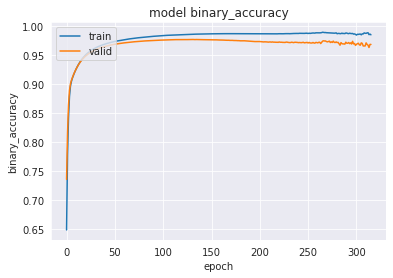

In [33]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


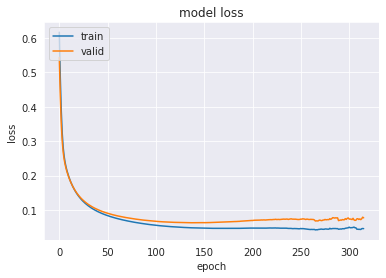

In [34]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
